## 1. Сбор данных

Цель: получить подробную информацию об инфраструктурных объектах (аптеки, школы, детсады и др.) города Казани для последующего анализа благоустройства каждого из районов.

### 1.1. Выгрузка OSM-файлов

Используя OpenStreetMap API, выгрузим в формате OSM всю имеющуюся информацию о постройках в Казани. Сама карта Казани делится на 400 кусочков для избежания 400-ой ошибки (Bad Request):

In [ ]:
from urllib.request import urlopen, urlretrieve

minlon = 48.9592
maxlon = 49.3016
minlat = 55.7168
maxlat = 55.8886
dlat = (maxlat - minlat) / 20
dlon = (maxlon - minlon) / 20

for i in range(20):
  for j in range(20):
    nminlat = minlat + dlat * i
    nmaxlat = minlat + dlat * (i + 1)
    nminlon = minlon + dlon * j
    nmaxlon = minlon + dlon * (j + 1)
    urlretrieve('https://www.openstreetmap.org/api/0.6/map?bbox=' + str(nminlon) +'%2C' + str(nminlat) +'%2C' + str(nmaxlon) +'%2C' + str(nmaxlat), '/content/drive/MyDrive/Data_Analysis/Projects/Itis/osm/kazan-map-' + str(i) + "-" + str(j) + ".osm")

    

### 1.2. Извлечение необходимых данных из OSM-файлов

Используя BeatifulSoup из пакета 'bs4' и проходясь по всем узлам с именем 'tag', извлечем необходимую информацию о казанских объектах:

In [ ]:
import pandas as pd
from bs4 import BeautifulSoup

v = []
for i in range(20):
  for j in range(20):
    xml = open('/content/drive/MyDrive/Data_Analysis/Projects/Itis/osm/kazan-map-' + str(i) + "-" + str(j) + ".osm", mode = 'r', encoding='utf-8')
    soup = BeautifulSoup(xml, 'lxml')
    for node in soup.find_all('node'):
      info = [None, None, None, None, None]
      flag = False
      for tag in node('tag'):
        if (tag['k'] == 'shop' and (tag['v'] == 'supermarket' or tag['v'] == 'convenience' or tag['v'] == 'general')):
          info[0] = tag['v']
          flag = True
        if (tag['k'] == 'amenity' and (tag['v'] == 'school' or tag['v'] == 'kindergarten' or tag['v'] == 'university' or tag['v'] == 'parking' or tag['v'] == 'hospital' or tag['v'] == 'pharmacy' or tag['v'] == 'fuel')):
          info[0] = tag['v']
          flag = True
        if (tag['k'] == 'name' or tag['k'] == 'brand'):
          info[1] = tag['v']
        if (flag):
          info[2] = node['lat']
          info[3] = node['lon']
          flag = False
    
      if (info[0] != None):
        v.append(info)

Заметим также, что часть построек осталась под узлом с именем 'way'. Аналогично предыдущему случаю извлечем информацию о постройках:

In [ ]:
for i in range(20):
  for j in range(20):
    xml = open('/content/drive/MyDrive/Data_Analysis/Projects/Itis/osm/kazan-map-' + str(i) + "-" + str(j) + ".osm", mode = 'r', encoding='utf-8')
    soup = BeautifulSoup(xml, 'lxml')
    for way in soup.find_all('way'):
      info = [None, None, None, None, None]
      flag = False
      for tag in way('tag'):
        if (tag['k'] == 'shop' and (tag['v'] == 'supermarket' or tag['v'] == 'convenience' or tag['v'] == 'general')):
          info[0] = tag['v']
          flag = True
        if (tag['k'] == 'amenity' and (tag['v'] == 'school' or tag['v'] == 'kindergarten' or tag['v'] == 'university' or tag['v'] == 'parking' or tag['v'] == 'hospital' or tag['v'] == 'pharmacy' or tag['v'] == 'fuel')):
          info[0] = tag['v']
          flag = True
        if (tag['k'] == 'leisure' and tag['v'] == 'park'):
          info[0] = tag['v']
          flag = True
        if (tag['k'] == 'name' or tag['k'] == 'brand'):
          info[1] = tag['v']
        if (flag):
          for node in soup.find_all('node'):
            if (node['id'] ==(way('nd')[0]['ref'])):
             info[2] = node['lat']
             info[3] = node['lon']
             break
      if (info[0] != None):
        v.append(info) 

### 1.3. Создание CSV-файла с данными

Прежде чем преобразовывать данные в удобный csv-формат, определим функцию get_district для сбора информации о том, в каком районе находится та или иная постройка. Для данной процедуры было использовано API BigDataCloud:

In [ ]:
import json

def get_district(lat, lon):
  if (lat == None or lon == None):
    return None
  response = urlopen(f'https://api.bigdatacloud.net/data/reverse-geocode-client?latitude={lat}&longitude={lon}&localityLanguage=ru')
  data = json.loads(response.read())
  return data['locality']

In [ ]:
data = pd.DataFrame(data = v, columns = ['type', 'name', 'lat', 'lon', 'district'])

data['district'] = data.apply(lambda row: get_district(row.lat, row.lon), axis = 1)
data.to_csv('/content/drive/MyDrive/data.csv', sep='\t', encoding='utf-8')


### 1.4 Загрузка дополнительных данных

Позднее, датасет с данными о квартирых с ресурса 'ЦИАН' понадобится для последующего анализа влияния местонахождения квартиры на её стоимость

Загрузим сами данные:

In [1]:
import pandas as pd

In [2]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
   print('User uploaded file «{name}» with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
data = pd.read_excel('/content/drive/MyDrive/cian.xlsx')
data.head()

Rooms   Latitude  Longitude  ...            Regionname     CianId    Price
0    3.0  55.679839  49.200358  ...       р-н Приволжский  246656269  5833697
1    2.0  55.785448  49.191844  ...         р-н Советский  224003481  6750000
2    2.0  55.822235  49.150970  ...  р-н Ново-Савиновский  244411488  8100000
3    3.0  55.801245  48.953167  ...         р-н Кировский  243246789  8041178
4    1.0  55.801834  49.195973  ...         р-н Советский  240670978  5139900

[5 rows x 10 columns]

## 2. Визуализация данных OpenStreetMap

Цель: построить визуализацию при помощи python и js-библиотек, на их основе построить выводы о способах и необходимости улучшения инфраструктуры того или иного района Казани.

### 2.1. Представление данных на карте с помощью Leaflet. Анализ их местоположения и инфраструктуры районов.

Leaflet — библиотека с открытым исходным кодом, написанная на JavaScript, предназначенная для отображения карт на веб-сайтах. Поддерживает большинство мобильных и стационарных платформ из числа тех, что поддерживают HTML5 и CSS3.

#### 2.1.1. Работа с библиотекой Leaflet


Исходники: https://github.com/realsanya/js-leaflet-geo

Все объекты представлены в виде меток. Над каждой меткой изображается блок с информацией об объекте: тип, имя, район. Для каждого типа объекта своя карта. Для кластеризации маркеров на карте использован плагин Leaflet.markercluster. При щелчке на кластер мы приближаемся к его границам. Кластеры различаются по цветам в зависимости от количества объектов (small - зеленый, medium - желтый, large - оранжевый). С помощью плагина Lefalet.GeoSearch на карту добавлена форма поиска по адресу. 

#### 2.1.2. Результаты работы с библиотекой Leaflet


Ниже представлены скриншоты и описание получившихся карт. 


Блок с информацией об объекте:

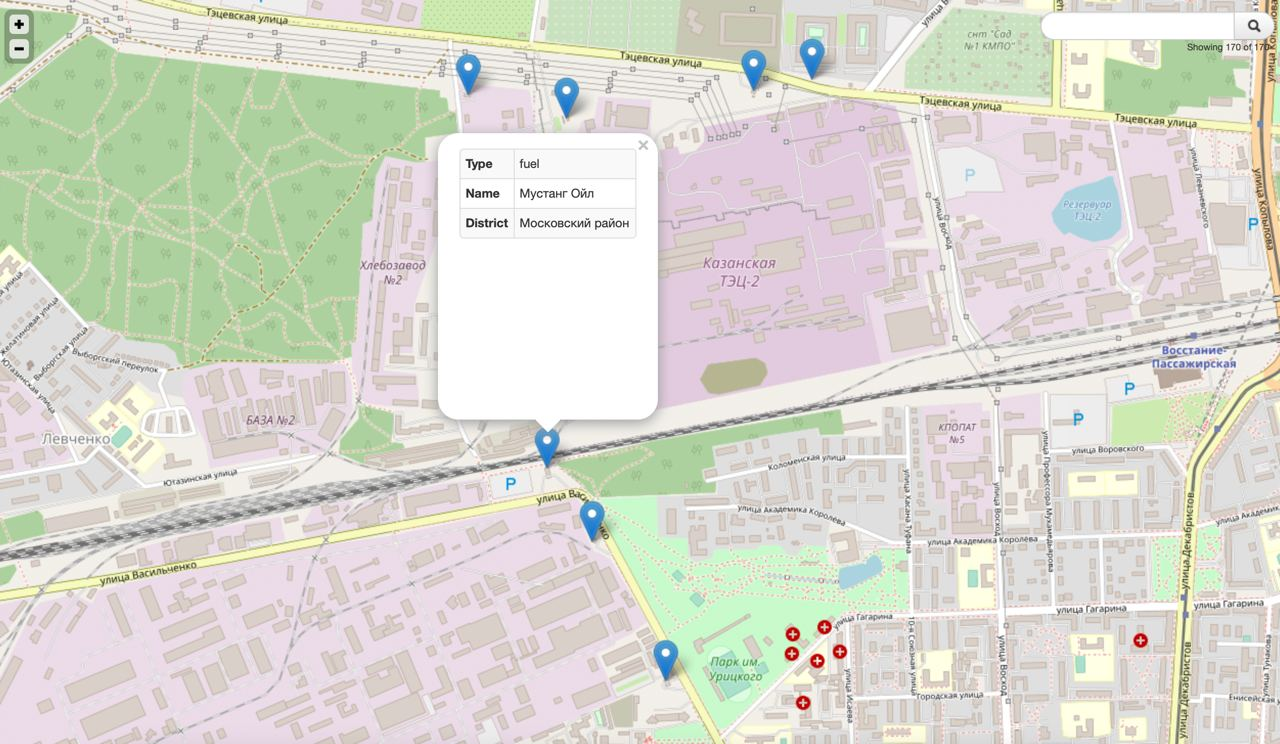

Все объекты:

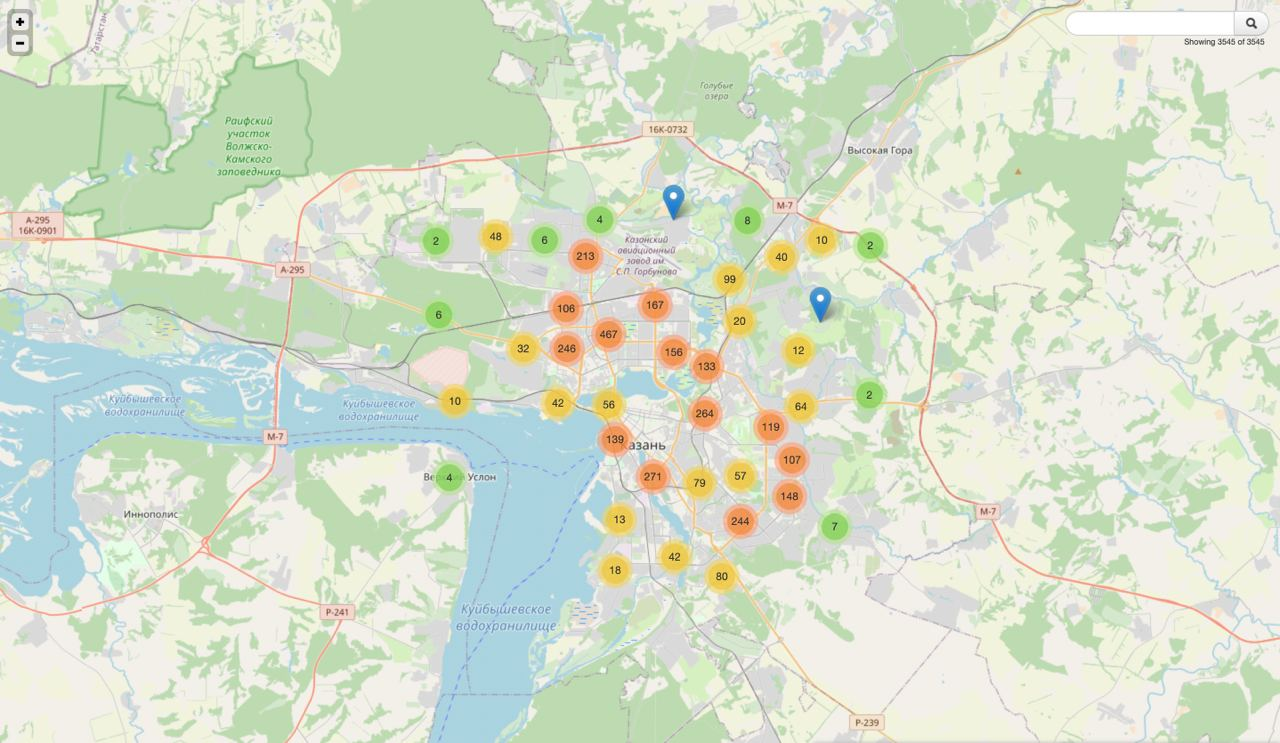

Школы(тип объекта 'school'):


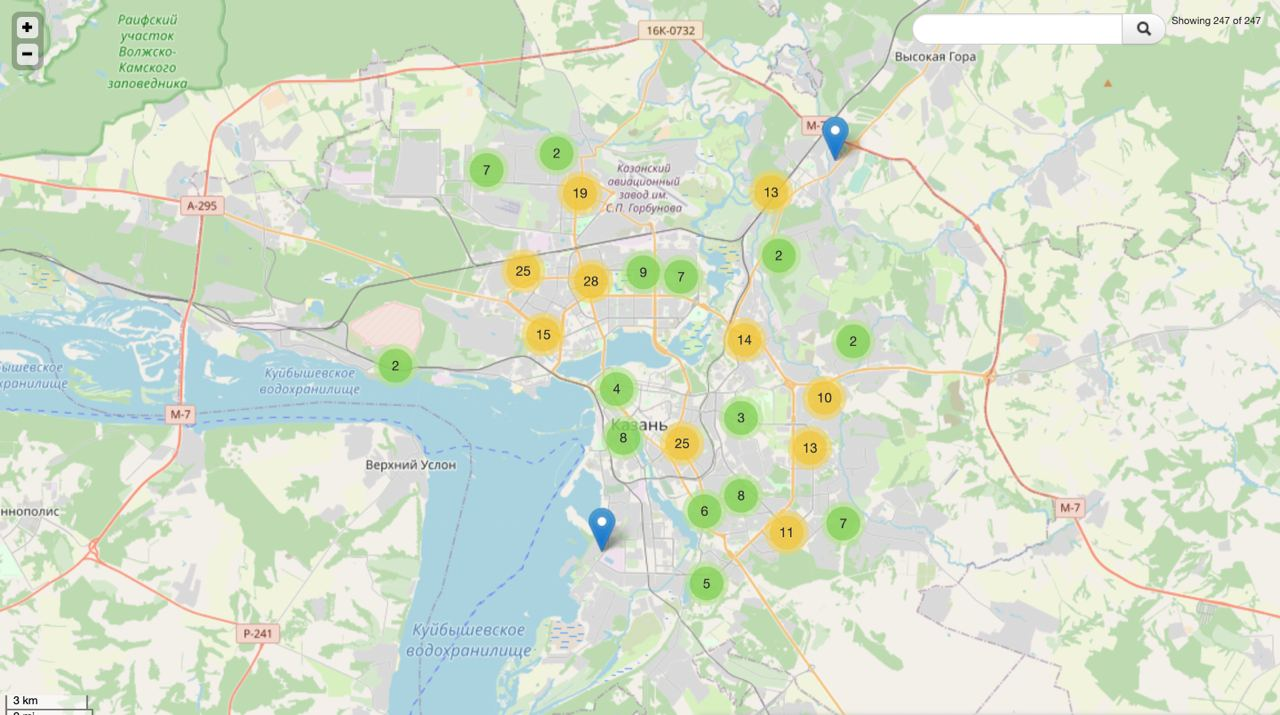

Магазины(тип объекта 'shop'):

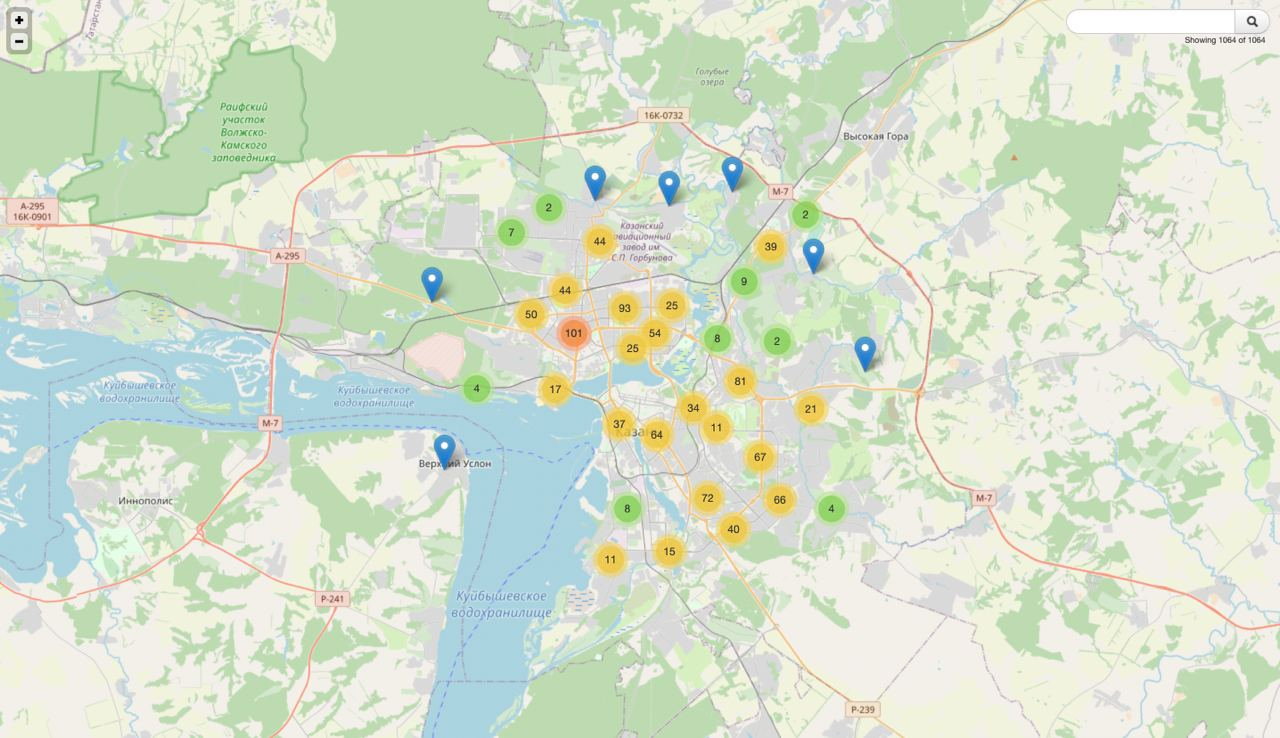

Заправки(тип объекта 'fuel'):


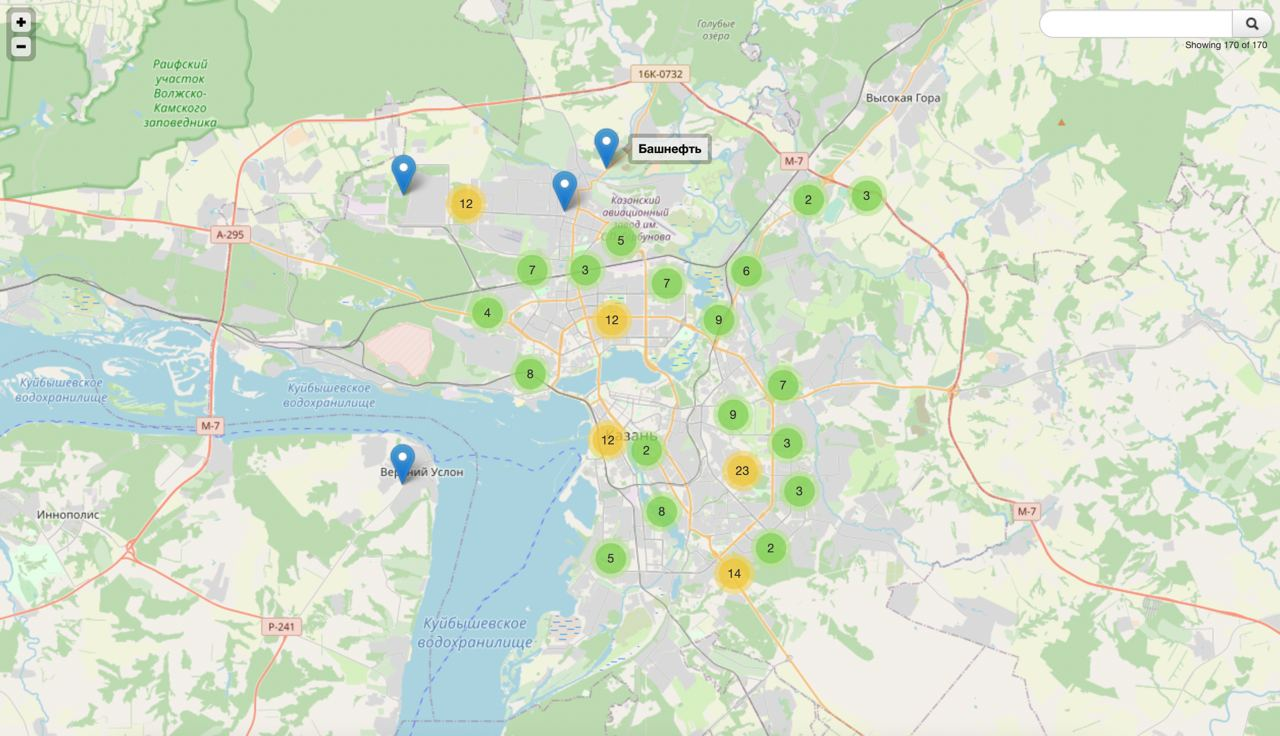

Больницы и поликлиники(тип объекта 'hospital'):

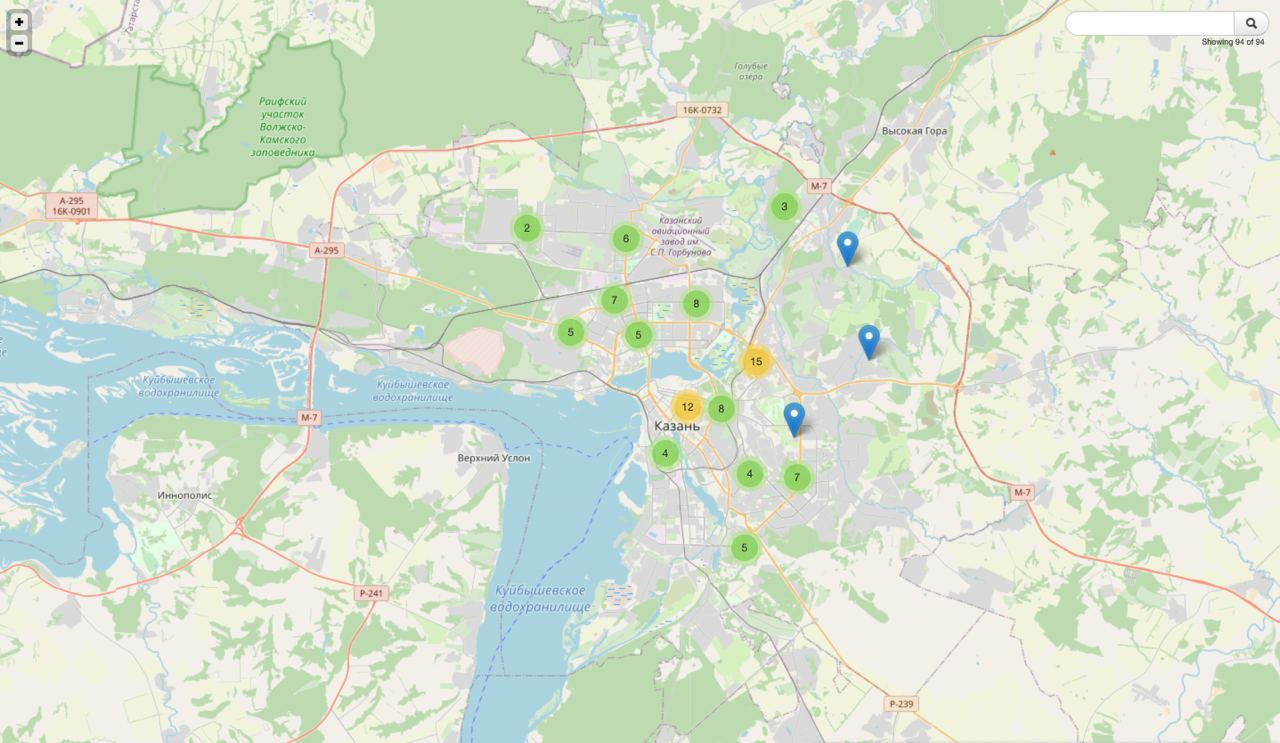

Парковки(тип объекта 'parking'):

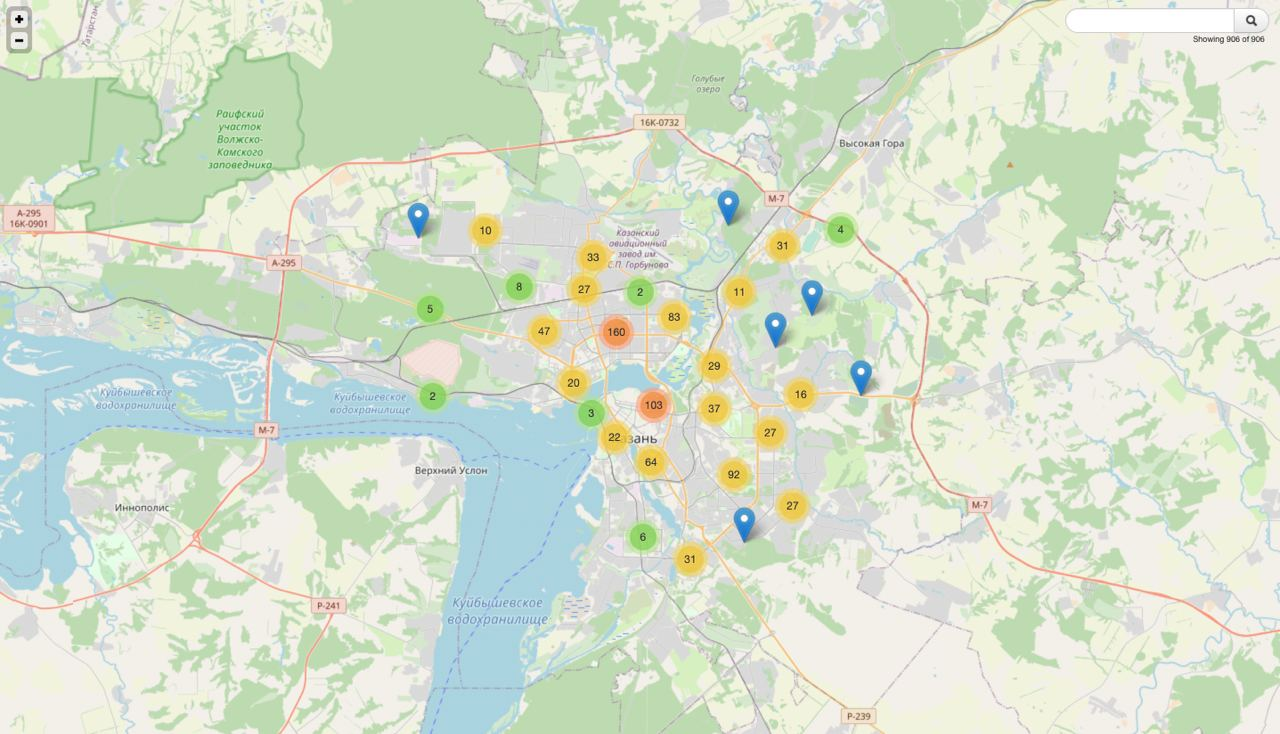

Детские сады(тип объекта 'kindergarten'):

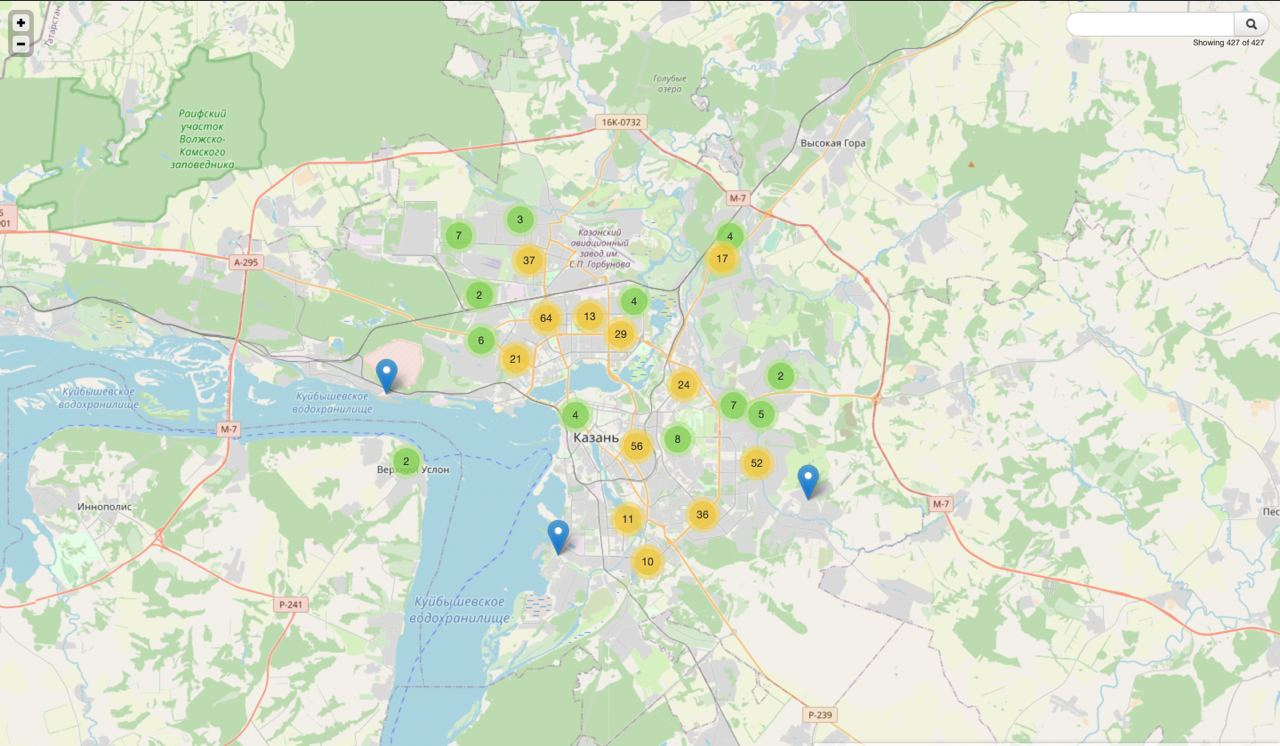

Аптеки(тип объекта 'pharmacy'):


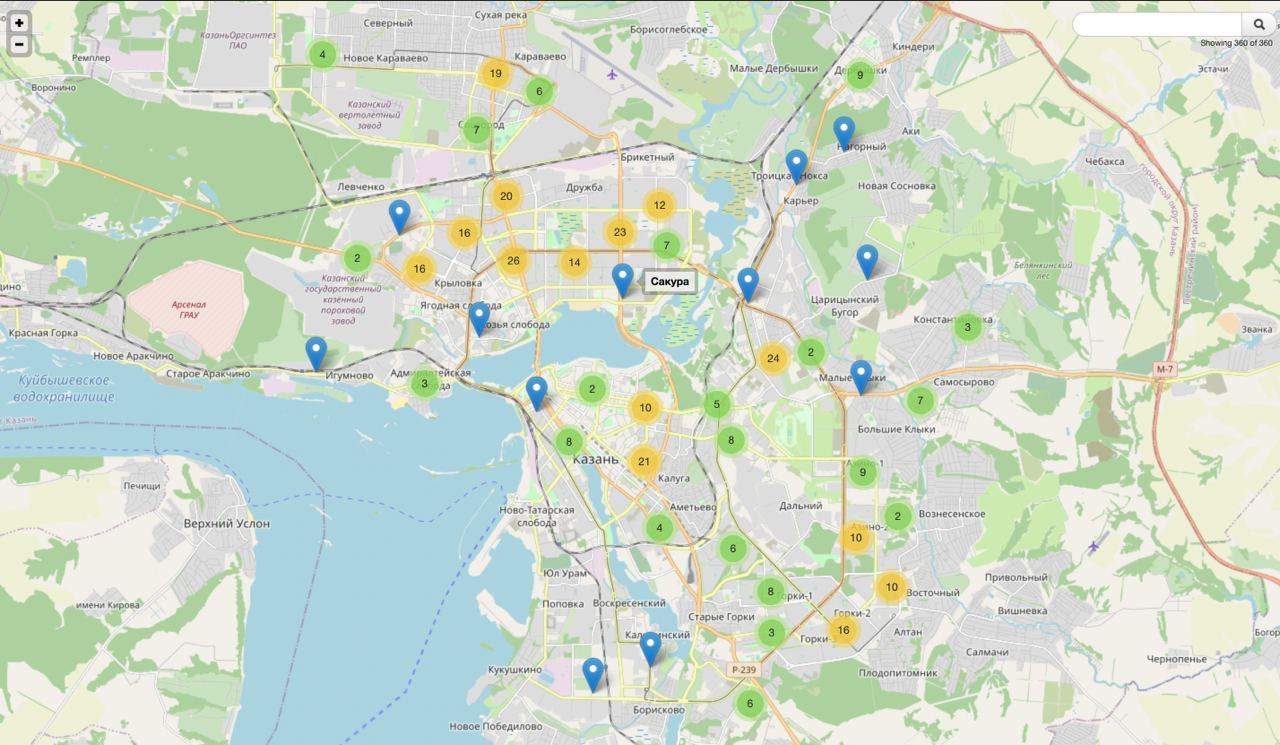

Парки(тип объекта 'park'):

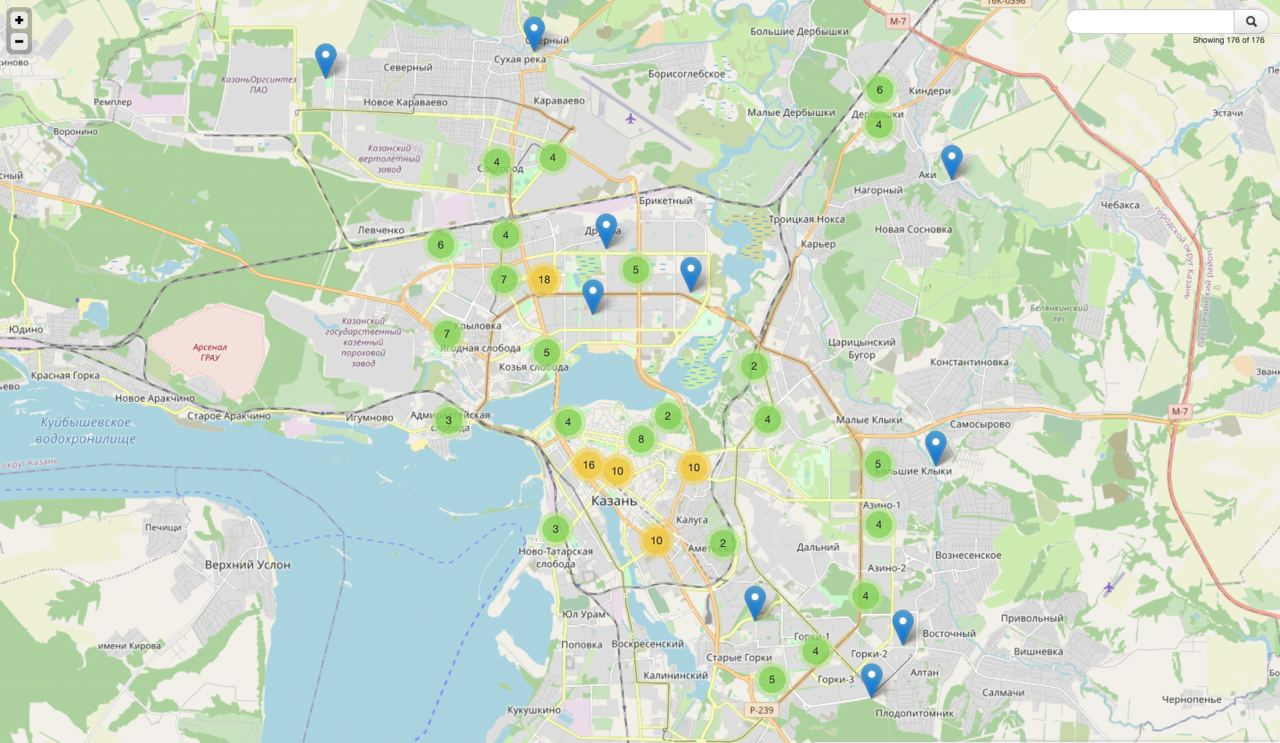

Университеты(тип объекта 'university'):

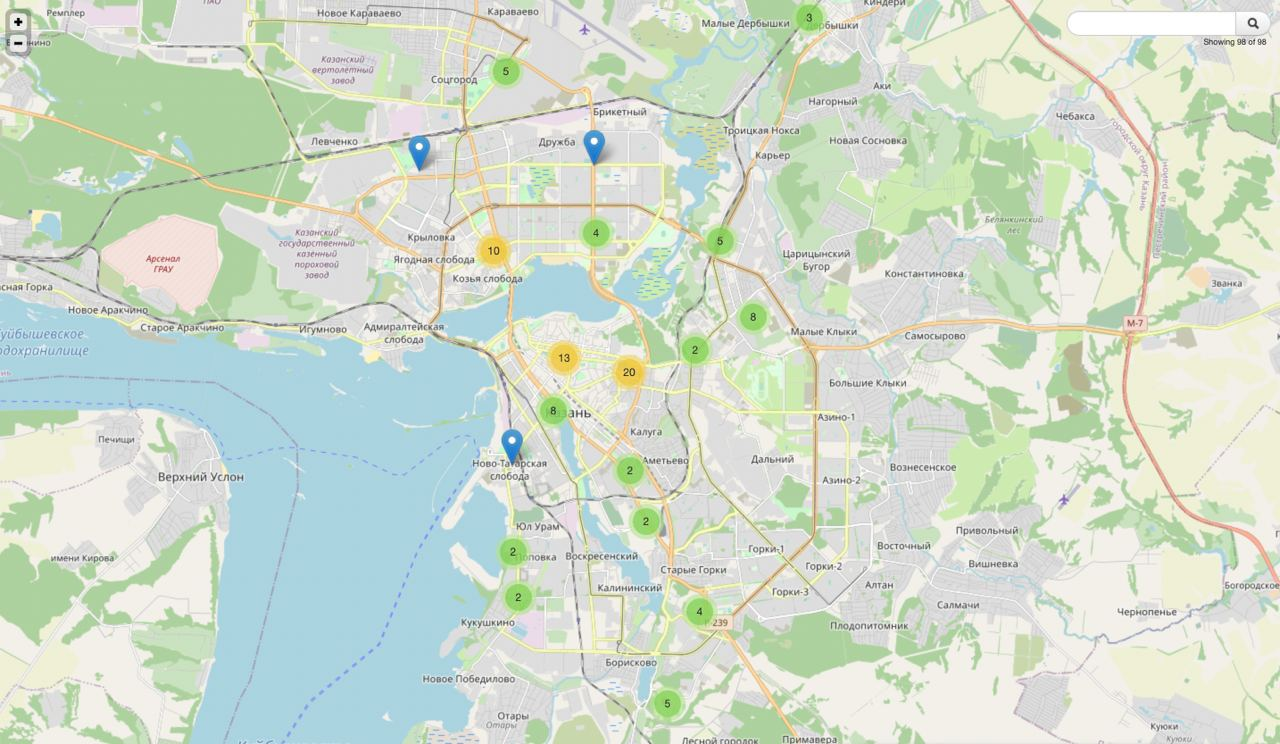

#### 2.1.3 Рекомендации


После анализа инфраструктуры с помощью визуализации на карте можно выявить актуальные для каждого конкретного района инфраструктурные проблемы и предложить рекомендации по их исправлению. 

**Советский район.**
Крупнейший по площади и самый приближенный к центру из всех «спальных» районов Казани. 
В этом районе не развит городской ландшафт - это сады и парки, скверы и бульвары. Многие жители и туристы города приезжают в Советский район лишь для посещения крупных торговых комплексов - "Мега", "Южный", "Горки-парк". В 2020 году с популяризацией парка "Горькинско-Ометьевский лес" ситуация немного улучшилась, но этого недостаточно для самого густонаселенного района города.

Парки Советского района:

**Здесь должна быть картинка** 

**Приволжский район.** Район достаточно развит по многим характеристикам. Большой толчок к развитию и популяризации этого района стала подготовка к Универсиаде 2013 года. Инфраструктура предлагает 28 учреждений здравоохранения и почти 90 учебных заведений всех ступеней — от детских садов до ВУЗов. Но развита она неравномерно.

Объекты Приволжского района: 


**Здесь должна быть картинка**

**Кировский район.** Район считается самым "зеленым" в Казани. Инфраструктура представлена почти 60-ю учебными заведениями во главе с Казанским энергетическим университетом. Минусом является отсутствие крупных торговых центров.

Магазины Кировского района:

**Здесь должна быть картинка**

**Авиастроительный район.** За культуру и образование района отвечают более 60 учебных заведений, среди которых ни одного ВУЗа. Также здесь довольно низкое количество аптек и магазинов.

Аптеки Авиастроительного района:

**Здесь должна быть картинка**

**Московский район.** Район сравнительно молодой. Образование возложено на 60 учебных заведений во главе с Академией социального образования. Сфера городского ландшафта не развита, району не хватает парков и скверов.

Парки Московского района:

**Здесь должна быть картинка**

**Вахитовский район.** Сердце культурной жизни и образования. На сравнительно небольшой территории расположились 80 образовательных учреждений, среди которых 18 ВУЗов. Недостатком района считается нехватка парковочного места и заправок.

Парковки Вахитовского района:

**Здесь должна быть картинка**

**Ново-Савиновский район.** В этом районе ни одного ВУЗа, зато много школ и гимназий. Район преобладает торгово-развлекательными центрами и магазинами. Заметно недостаточное количество детских садов и больниц по сравнению с другими районами города.

Детские сады Ново-Савиновского района:

**Здесь должна быть картинка**

### 2.2. Анализ инфраструктуры с помощью графиков

Plotly - это платформа, работающая на JSON, формате, в котором параметры передаются в API plotly в форматах словарей. Мы можем получить доступ к этому API в Python.

#### 2.2.1. Подготовка библиотеки Plotly

Для начала необходимо установить библиотеку, т.к. она не входит ни в стандартный пакет, ни в Anaconda. Для этого рекомендуется использовать pip:

In [11]:
!pip install chart-studio

     |████████████████████████████████| 71kB 4.2MB/s 


In [12]:
!pip install plotly

Для дальнейшей работы cгенерируем на странице https://plot.ly/settings/api наш персональный API Key и вставим его и логин в функцию sign_in:

In [13]:
import chart_studio.plotly as py

py.sign_in('piauaw', 'FA6pPbgzoGM9VuBImVV3')

from plotly.graph_objs import *

In [14]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

import numpy as np
import pandas as pd

#### 2.2.2. Работа с библиотекой Plotly

In [15]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
   print('User uploaded file «{name}» with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

KeyboardInterrupt: ignored

In [17]:
cian = pd.read_excel('cian.xlsx')
cian.head()

FileNotFoundError: ignored

In [ ]:
map_data = pd.read_excel('data.xlsx')
map_data.head()

Unnamed: 0         type  ...        lon           district
0           0  supermarket  ...  49.105166  Приволжский район
1           1         fuel  ...  49.172206  Приволжский район
2           2      parking  ...  49.173152  Приволжский район
3           3       school  ...  49.170567  Приволжский район
4           4  supermarket  ...  49.191794  Приволжский район

[5 rows x 6 columns]

In [ ]:
import plotly.graph_objects as go

def change_value(x):
  if (x == 'supermarket' or x == 'convenience' or x == 'general'):
    return 'shop'
  return x

districts = ['Приволжский район', 'Советский район', 'Вахитовский район', 'Кировский район', 'Московский район', 'Авиастроительный район', 'Ново-Савиновский район']
map_data['type'] = map_data.apply(lambda row: change_value(row['type']), axis = 1)
types = map_data['type'].unique()
print(types)
for type in types:
  counts = []
  for district in districts:
    counts.append(map_data.loc[(map_data['type'] == type) & (map_data['district'] == district)].count()['district'])
  fig = go.Figure(
      data = [go.Bar(x=districts, y=counts)], layout = dict(title=dict(text=f'Кол-во объектов типа \'{type}\' в Казани'))
  )
  fig.show()

['shop' 'fuel' 'parking' 'school' 'pharmacy' 'kindergarten' 'hospital'
 'university' 'park']


In [ ]:
for district in districts:
  df = map_data[map_data['district'] == district]
  fig = px.pie(df, title = district, names='type')
  fig.show()

In [ ]:
cian.dropna(subset = ['Rooms', 'Regionname', 'BuildYear'], inplace = True)
cian.head()


Rooms   Latitude  Longitude  ...            Regionname     CianId    Price
0    3.0  55.679839  49.200358  ...       р-н Приволжский  246656269  5833697
1    2.0  55.785448  49.191844  ...         р-н Советский  224003481  6750000
2    2.0  55.822235  49.150970  ...  р-н Ново-Савиновский  244411488  8100000
3    3.0  55.801245  48.953167  ...         р-н Кировский  243246789  8041178
4    1.0  55.801834  49.195973  ...         р-н Советский  240670978  5139900

[5 rows x 10 columns]

In [ ]:
districts = cian['Regionname'].unique()
average_prices = {}
for district in districts:
  mean_price = cian[cian['Regionname'] == district]['Price'].mean()
  average_prices[mean_price] = district
print(average_prices)

{5810374.739619377: 'р-н Приволжский', 6231526.906578948: 'р-н Советский', 7867257.211707317: 'р-н Ново-Савиновский', 4803583.790825688: 'р-н Кировский', 11398964.45: 'р-н Вахитовский', 3699550.707165109: 'р-н Авиастроительный', 4352119.33939394: 'р-н Московский'}


In [ ]:
sizes = []
for el in average_prices.keys():
  sizes.append(el/100000)
print(sizes)

[58.10374739619377, 62.31526906578948, 78.67257211707317, 48.03583790825688, 113.9896445, 36.99550707165109, 43.5211933939394]


In [ ]:
prices = []
for el in average_prices.keys():
  prices.append(el)
print(prices)

[5810374.739619377, 6231526.906578948, 7867257.211707317, 4803583.790825688, 11398964.45, 3699550.707165109, 4352119.33939394]


In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter(
    x=cian['Regionname'].unique(),
    y= prices,
    mode='markers',
    marker= dict(
        size = sizes,
        color = np.arange(100, 300, 28)
    )
)])

fig.show()

In [ ]:
!pip install geopandas

In [ ]:
district_colors = {'р-н Приволжский':"#9966CC", 'р-н Советский': "#FF033E", 'р-н Ново-Савиновский': "#00BFFF", 'р-н Кировский': "#00FF00",
 'р-н Вахитовский': "#8A3324", 'р-н Авиастроительный': "#FDE910", 'р-н Московский': "#000080"} 
for district in district_colors.keys():
  cian.loc[cian['Regionname'] == district, 'color'] =  district_colors.get(district)
cian.head()

Rooms   Latitude  Longitude  ...     CianId    Price    color
0    3.0  55.679839  49.200358  ...  246656269  5833697  #9966CC
1    2.0  55.785448  49.191844  ...  224003481  6750000  #FF033E
2    2.0  55.822235  49.150970  ...  244411488  8100000  #00BFFF
3    3.0  55.801245  48.953167  ...  243246789  8041178  #00FF00
4    1.0  55.801834  49.195973  ...  240670978  5139900  #FF033E

[5 rows x 11 columns]

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

mapbox_access_token = "pk.eyJ1Ijoia2hlbHZpcmEiLCJhIjoiY2tweDRrNmZmMDYzOTJ2bGdnZXZsZjR1YiJ9.oOkdXs0y2lmN57dC7uSDqg"
fig = go.Figure()
districts = cian['Regionname'].unique()

for district in districts:
  cian_new = cian[cian['Regionname'] == district]
  fig.add_trace(
          go.Scattermapbox(          
            lat=cian_new['Latitude'],
            lon=cian_new['Longitude'],
            customdata = cian_new,
            name=district,
            mode='markers',
            hovertext=cian_new['Price'],
            hovertemplate = "%{lat}, %{lon} <br> %{hovertext} <br> BuildingArea: %{customdata[4]} <br> Rooms: %{customdata[0]} <br> BuildYear: %{customdata[5]}",
            marker=go.scattermapbox.Marker(
                size=10,
                color=district_colors.get(district)
            ),
          ))
fig.update_layout(
    mapbox_style="open-street-map",
    autosize=True,
    hovermode='closest',
    title="Распределение объявлений о продаже недвижимости в Казани",
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=55.7887,
            lon=49.1221
        ),
        pitch=0,
        zoom=10
    ),
)
fig.show()

## 3. Предобработка данных 

In [ ]:
data.describe()

Rooms      Latitude  ...        CianId         Price
count  9566.000000  13884.000000  ...  1.388400e+04  1.388400e+04
mean      2.082375     55.792140  ...  2.397389e+08  6.731559e+06
std       0.947282      0.059855  ...  1.027328e+07  3.990604e+07
min       1.000000     54.862705  ...  3.204369e+07  4.600000e+03
25%       1.000000     55.756352  ...  2.374019e+08  3.520000e+06
50%       2.000000     55.796349  ...  2.434714e+08  4.980000e+06
75%       3.000000     55.828501  ...  2.459877e+08  7.100000e+06
max       6.000000     55.955403  ...  2.475539e+08  4.550000e+09

[8 rows x 8 columns]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13884 entries, 0 to 13883
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rooms         9566 non-null   float64
 1   Latitude      13884 non-null  float64
 2   Longitude     13884 non-null  float64
 3   Car           0 non-null      float64
 4   BuildingArea  13884 non-null  float64
 5   BuildYear     9443 non-null   float64
 6   Type          13884 non-null  object 
 7   Regionname    11301 non-null  object 
 8   CianId        13884 non-null  int64  
 9   Price         13884 non-null  int64  
dtypes: float64(6), int64(2), object(2)
memory usage: 1.1+ MB


### 3.1. Работа с пропущенными значениями

Заметим, что датасет имеет довольно большое количество NaN-значений, которые в последующей работе могут довольно сильно влиять на предсказательную модель:

In [ ]:
data.isnull().sum()

Rooms            4318
Latitude            0
Longitude           0
Car             13884
BuildingArea        0
BuildYear        4441
Type                0
Regionname       2583
CianId              0
Price               0
dtype: int64

Было установлено, что наиболее лучшим вариантом решения данной проблемы является удаление всех строк, имеющие NaN-значения. Удалим их: 

In [ ]:
data.dropna(subset = ['Rooms', 'Regionname', 'BuildYear'], inplace = True)


Посмотрим на результаты:

In [ ]:
data.isnull().sum()


Rooms              0
Latitude           0
Longitude          0
Car             6582
BuildingArea       0
BuildYear          0
Type               0
Regionname         0
CianId             0
Price              0
dtype: int64

In [ ]:
data.shape

(6582, 10)

### 3.2. Удаление неинформативных признаков

Удалим также, неинформативные и 'пустые' признаки:

In [ ]:
data.drop(['Car', 'CianId'], axis='columns', inplace=True)
data.head()

Rooms   Latitude  ...            Regionname    Price
0    3.0  55.679839  ...       р-н Приволжский  5833697
1    2.0  55.785448  ...         р-н Советский  6750000
2    2.0  55.822235  ...  р-н Ново-Савиновский  8100000
3    3.0  55.801245  ...         р-н Кировский  8041178
4    1.0  55.801834  ...         р-н Советский  5139900

[5 rows x 8 columns]

### 3.3. Преобразование категориальных признаков в номинальные

#### 3.3.1. Названия районов

Посмотрим на то, какие уникальные значения содержит в себе признак 'Regionname':

In [ ]:
data['Regionname'].unique()

array(['р-н Приволжский', 'р-н Советский', 'р-н Ново-Савиновский',
       'р-н Кировский', 'р-н Вахитовский', 'р-н Авиастроительный',
       'р-н Московский'], dtype=object)

Так как значений всего лишь 7, целесообразнее всего воспользоваться методом Integer Encoding, чтобы преобразовать названия районов в целочисленное значение:

In [ ]:
region_dict = {"р-н Приволжский": 6, "р-н Советский" : 3, "р-н Ново-Савиновский" : 1, "р-н Кировский" : 7, "р-н Вахитовский" : 2, "р-н Авиастроительный" : 5, "р-н Московский" : 4}
data.Regionname = data.Regionname.replace(to_replace=region_dict)

На выходе имеем:

In [ ]:
data.head()

Rooms   Latitude  Longitude  ...                 Type  Regionname    Price
0    3.0  55.679839  49.200358  ...  newBuildingFlatSale           6  5833697
1    2.0  55.785448  49.191844  ...             flatSale           3  6750000
2    2.0  55.822235  49.150970  ...             flatSale           1  8100000
3    3.0  55.801245  48.953167  ...  newBuildingFlatSale           7  8041178
4    1.0  55.801834  49.195973  ...  newBuildingFlatSale           3  5139900

[5 rows x 8 columns]

#### 3.3.2. Тип дома 

По аналогии с названиями районов, преобразуем тип дома в целое число:

In [ ]:
data['Type'].unique()
type_dict = {'newBuildingFlatSale' : 1, 'flatSale' : 2, 'houseSale' : 3, 'cottageSale' : 0, 'townhouseSale' : 4, 'houseShareSale' : 5}
data.Type = data.Type.replace(to_replace = type_dict)
data.head()

Rooms   Latitude  Longitude  ...  Type  Regionname    Price
0    3.0  55.679839  49.200358  ...     1           6  5833697
1    2.0  55.785448  49.191844  ...     2           3  6750000
2    2.0  55.822235  49.150970  ...     2           1  8100000
3    3.0  55.801245  48.953167  ...     1           7  8041178
4    1.0  55.801834  49.195973  ...     1           3  5139900

[5 rows x 8 columns]

### 3.4. Обработка выбросов

#### 3.4.1. Площадь квартиры

При помощи Plotly рассмотрим подробнее признак 'BuidingArea' на диаграмме размаха (ящик с усами). Видим, что признак имеет выбросы:

In [ ]:
px.box(y = data['BuildingArea']).show()

Удалим все 'нестандартные' объекты и посмотрим на результаты:

In [ ]:
data = data.drop(data[data['BuildingArea'] > 162].index)
px.box(y = data['BuildingArea']).show()

#### 3.4.2. Год сдачи или окончания строительства жилого дома

По аналогии с предыдущим признаком:

In [ ]:
px.box(y = data['BuildYear']).show()
data = data.drop(data[data['BuildYear'] < 1977].index)
px.box(y = data['BuildYear']).show()

#### 3.4.3. Цена жилого помещения

Аналогично c ценой:

In [ ]:
px.box(y = data['Price']).show()
data = data.drop(data[data['Price'] > 30000000].index)
px.box(y = data['Price']).show()

## 4. Обработка мультиколлинеарности

**Мультиколлинеарность** - наличие линейной зависимости между объясняющими переменными регрессионной модели. 

**Корреляционная зависимость** - статистическая взаимосвязь двух или более случайных величин (либо величин, которые можно с некоторой допустимой степенью точности считать таковыми). При этом изменения значений одной или нескольких из этих величин сопутствуют систематическому изменению значений другой или других величин

**Коэффициент Пирсона (r-Pearson)** - мера корреляции, подходящая для двух непрерывных(метрических переменных), измеренных на одной и той же выборке 

$$
r_{x, y} = \frac{n * \sum_{}(x_{i}-y_{i}) - (\sum_{}x_{i} * \sum_{}y_{i}) }{\sqrt{n * \sum_{}x_{i}^2 - (\sum_{}x_{i})^2 * n * \sum_{}y_{i}^2 - (\sum_{}y_{i})^2}}
$$

**Коэффициент Спирмена (r-Spearman's)** - мера корреляции, подходящая для двух переменных, измеренных в ранговой шкале

$$
r_{s} = 1 - \frac{6 * \sum{}(x_{i} - y_{i})^2}{n * (n^2 - 1)}
$$

Заметим, что для нашего датасета наиболее сильную корреляционную связь с целовой переменной 'Price' имеют признаки 'BuildingArea' и 'Regionname'. В частности, важно обратить внимание на умеренную зависимость стоимости жилого помещения от района:

In [ ]:
data.corr(method = 'spearman').style.format("{:.2}").background_gradient(cmap='coolwarm', axis=1)

In [ ]:
data.corr().style.format("{:.2}").background_gradient(cmap='coolwarm', axis=1)

## 5. Нормализация признаков

Выделим выбранные после анализа корреляционной зависимости признаки и целевую в отдельные переменные:

In [ ]:
X = pd.DataFrame(data = data, columns = ['Rooms', 'BuildingArea', 'BuildYear', 'Regionname', 'Type'])
Y = data['Price']

In [ ]:
X.head()

Rooms  BuildingArea  BuildYear  Regionname  Type
0    3.0         74.32     2021.0           6     1
1    2.0         71.00     2019.0           3     2
2    2.0         77.60     2006.0           1     2
3    3.0         88.20     2021.0           7     1
4    1.0         43.70     2023.0           3     1

Цены растут по мере линейного увеличения BuildingArea и BuildYear

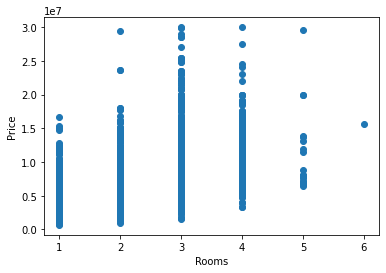

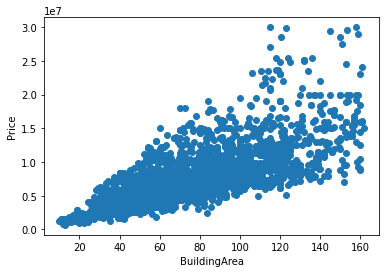

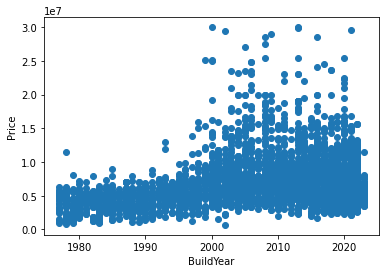

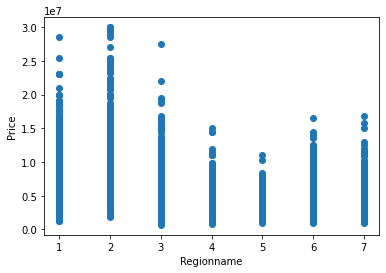

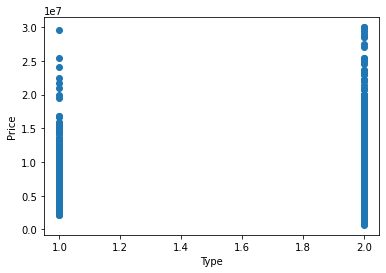

In [ ]:
import matplotlib.pyplot as plt

for i, column in enumerate(X.columns):
    plt.figure()
    plt.scatter(X.values[:, i], Y)
    plt.ylabel('Price')
    plt.xlabel(column)

Для каждой пары объектов (столбцов) в наборе данных мы можем визуализировать график рассеяния для каждой пары вместе с 
гистограммой объекта по диагонали на одном изображении с помощью функции

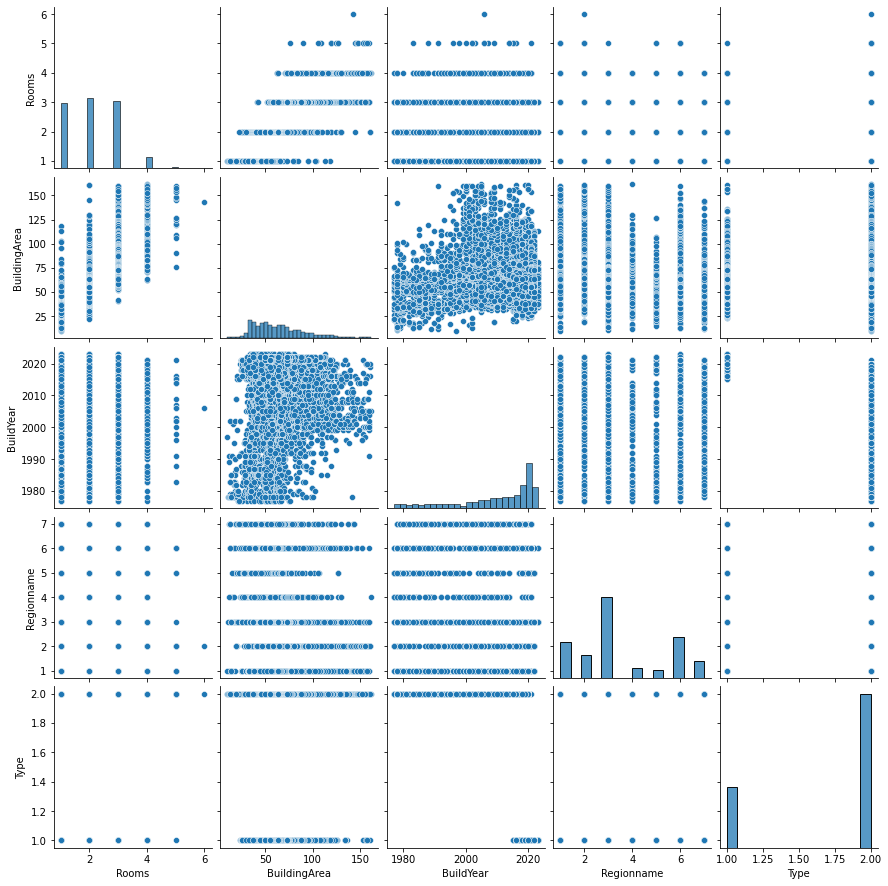

In [ ]:
import seaborn as sns
sns.pairplot(X)

Данные не нормализованы (это означает, что существуют разные масштабы данных).

Приведем значения каждого столбца к шкале $[0..1]$ с помощью следующего преобразования:
$$
x' = \frac{x - min(x)}{max(x)}
$$


Для этого применим готовый класс MinMaxScaler из пакета sklearn:

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

min_max_scaler = MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

X_scaled.head()

Rooms  BuildingArea  BuildYear  Regionname  Type
0    0.4      0.423995   0.956522    0.833333   0.0
1    0.2      0.402109   0.913043    0.333333   1.0
2    0.2      0.445616   0.630435    0.000000   1.0
3    0.4      0.515491   0.956522    1.000000   0.0
4    0.0      0.222149   1.000000    0.333333   0.0

## 6. Предсказательные модели

Построим несколько различных моделей для прогнозирования стоимости недвижимости в Казани. Мы не знаем, какие алгоритмы будут хороши для этой задачи.


Давайте протестируем 6 различных алгоритмов:


*   Линейная регрессия
*   Lasso-регрессия
*   Ridge-регрессия
*   Случайный лес
*   Градиентный бустинг
*   Метод k ближайших соседей

### 6.1. Линейная регрессия

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.3, random_state=0)
model = LinearRegression()
model = model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print('MAE train: {:.3f}, test: {:.3f}'.format(
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test, y_test_pred)))
print('MSE train: {:.3f}, test: {:.3f}'.format(
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: {:.3f}, test: {:.3f}'.format(
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

print('RMSE train: {:.3f}, test: {:.3f}'.format(
        np.sqrt(mean_squared_error(y_train, y_train_pred)),
        np.sqrt(mean_squared_error(y_test, y_test_pred))))

MAE train: 1188057.631, test: 1185891.159
MSE train: 3629872478635.094, test: 3833467533908.612
R^2 train: 0.685, test: 0.688
RMSE train: 1905222.422, test: 1957924.292


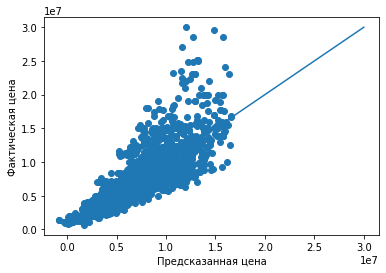

In [ ]:
plt.scatter (y_train_pred, y_train)
plt.xlabel ('Предсказанная цена')
plt.ylabel ('Фактическая цена')
plt.plot ( [ Y.min (), Y.max () ] , [ [ Y.min () ] , [ Y.max () ] ] )

### 6.2. Lasso-регрессия

Lasso-регрессия решает задачу минимизации среднеквардатичной ошибки с L1-регуляризацией:
$$\Large error(X, y, \beta) = \frac{1}{2n} \sum_{i=1}^n {(y_i - \beta^Tx_i)}^2 + \alpha \sum_{i=1}^n |\beta_i|$$

где $y = \beta^Tx$ - уравнение гиперплоскости, зависящее от параметров модели $\beta$, $n$-число объектов в выборке X, y - значения целевого признака, $\alpha$ - коэффициент регуляризации.

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LassoCV, RidgeCV, Lasso, Ridge

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size = 0.3)
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
lasso.coef_


array([-3198448.15674789, 16127621.96579023,  2083513.10917485,
       -2155832.04236894,   421531.80145369])

In [ ]:
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

print('MAE train: {:.3f}, test: {:.3f}'.format(
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test, y_test_pred)))
print('MSE train: {:.3f}, test: {:.3f}'.format(
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: {:.3f}, test: {:.3f}'.format(
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

print('RMSE train: {:.3f}, test: {:.3f}'.format(
        np.sqrt(mean_squared_error(y_train, y_train_pred)),
        np.sqrt(mean_squared_error(y_test, y_test_pred))))

MAE train: 1179726.769, test: 1205941.200
MSE train: 3727159693747.247, test: 3599387883879.303
R^2 train: 0.684, test: 0.693
RMSE train: 1930585.324, test: 1897205.282


Lasso-регрессия служит методом отбора признаков.

> Блок с отступами



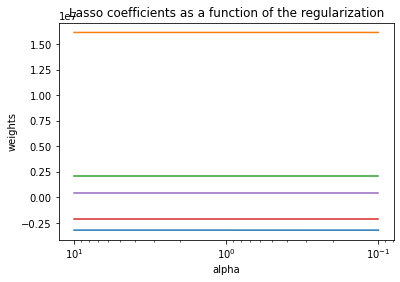

In [ ]:
n_alphas = 200
alphas = np.linspace(0.1, 10, n_alphas)
lasso = Lasso()
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

Теперь определим лучшее значение $\alpha$ в процессе кросс-валидации:

In [ ]:
lasso_cv = LassoCV(alphas=alphas, 
                   cv=3, random_state=42)
lasso_cv.fit(X_train, y_train)

LassoCV(alphas=array([ 0.1       ,  0.14974874,  0.19949749,  0.24924623,  0.29899497,
        0.34874372,  0.39849246,  0.44824121,  0.49798995,  0.54773869,
        0.59748744,  0.64723618,  0.69698492,  0.74673367,  0.79648241,
        0.84623116,  0.8959799 ,  0.94572864,  0.99547739,  1.04522613,
        1.09497487,  1.14472362,  1.19447236,  1.24422111,  1.29396985,
        1.34371859,  1.39346734,  1.44321608,  1.49296482,  1.54271357,
        1.5924...
        9.30351759,  9.35326633,  9.40301508,  9.45276382,  9.50251256,
        9.55226131,  9.60201005,  9.65175879,  9.70150754,  9.75125628,
        9.80100503,  9.85075377,  9.90050251,  9.95025126, 10.        ]),
        copy_X=True, cv=3, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=42, selection='cyclic', tol=0.0001,
        verbose=False)

In [ ]:
lasso_cv.coef_

array([-3196982.22759861, 16126195.64073933,  2083467.3406643 ,
       -2155789.02337995,   421478.01460914])

In [ ]:
lasso_cv.alpha_

10.0

### 6.3. Ridge-регрессия

Ridge-регрессия (или гребневая регрессия) решает задачу минимизации среднеквардатичной ошибки с L2-регуляризацией:
$$\Large error(X, y, \beta) = \frac{1}{2n} \sum_{i=1}^n {(y_i - \beta^Tx_i)}^2 + \alpha \sum_{i=1}^n \beta_i^2$$

где $y = \beta^Tx$ - уравнение гиперплоскости, зависящее от параметров модели $\beta$, $n$-число объектов в выборке X, y - значения целевого признака, $\alpha$ - коэффициент регуляризации.

В sklearn реализован специальный класс [RidgeCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV) для кросс-валидации с Ridge-регрессией.

In [ ]:
n_alphas = 200
ridge_alphas = np.logspace(-2, 10, n_alphas)

In [ ]:
ridge_cv = RidgeCV(alphas=ridge_alphas,
                   cv=3)
ridge_cv.fit(X_train, y_train)

RidgeCV(alphas=array([1.00000000e-02, 1.14895100e-02, 1.32008840e-02, 1.51671689e-02,
       1.74263339e-02, 2.00220037e-02, 2.30043012e-02, 2.64308149e-02,
       3.03677112e-02, 3.48910121e-02, 4.00880633e-02, 4.60592204e-02,
       5.29197874e-02, 6.08022426e-02, 6.98587975e-02, 8.02643352e-02,
       9.22197882e-02, 1.05956018e-01, 1.21738273e-01, 1.39871310e-01,
       1.60705282e-01, 1.84642494e-0...
       7.14942899e+08, 8.21434358e+08, 9.43787828e+08, 1.08436597e+09,
       1.24588336e+09, 1.43145894e+09, 1.64467618e+09, 1.88965234e+09,
       2.17111795e+09, 2.49450814e+09, 2.86606762e+09, 3.29297126e+09,
       3.78346262e+09, 4.34701316e+09, 4.99450512e+09, 5.73844165e+09,
       6.59318827e+09, 7.57525026e+09, 8.70359136e+09, 1.00000000e+10]),
        cv=3, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)

In [ ]:
ridge_cv.alpha_

0.1398713102647238

In [ ]:
ridge = Ridge(alpha=0.01)
ridge.fit(X_train, y_train)
y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)

print('MAE train: {:.3f}, test: {:.3f}'.format(
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test, y_test_pred)))
print('MSE train: {:.3f}, test: {:.3f}'.format(
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: {:.3f}, test: {:.3f}'.format(
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

print('RMSE train: {:.3f}, test: {:.3f}'.format(
        np.sqrt(mean_squared_error(y_train, y_train_pred)),
        np.sqrt(mean_squared_error(y_test, y_test_pred))))

MAE train: 1179711.925, test: 1205932.156
MSE train: 3727159924349.997, test: 3599383273731.864
R^2 train: 0.684, test: 0.693
RMSE train: 1930585.384, test: 1897204.067


В случае Ridge-регрессии никакие праметры не зануляются - они могут быть очень малыми, но не нулевыми

In [ ]:
ridge_cv.coef_

array([-2889653.06461684, 15427004.61385436,  2139128.54512229,
       -2157130.57221545,   331250.32042983])

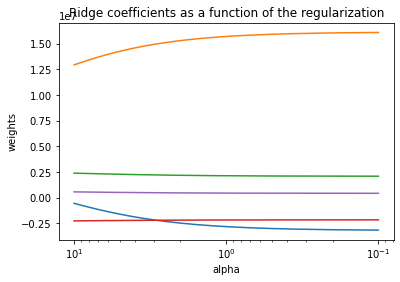

In [ ]:
n_alphas = 200
ridge_alphas = np.logspace(-2, 10, n_alphas)
model = Ridge()

coefs = []
for a in alphas:
    model.set_params(alpha=a)
    model.fit(X_train, y_train)
    coefs.append(model.coef_)
    
ax = plt.gca()
#ax.set_color_cycle(['b', 'r', 'g', 'c', 'k', 'y', 'm'])

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

### 6.4. Случайный лес

In [ ]:
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size = 0.1)
model = RandomForestRegressor()
model = model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print('MAE train: {:.3f}, test: {:.3f}'.format(
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test, y_test_pred)))
print('MSE train: {:.3f}, test: {:.3f}'.format(
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: {:.3f}, test: {:.3f}'.format(
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

print('RMSE train: {:.3f}, test: {:.3f}'.format(
        np.sqrt(mean_squared_error(y_train, y_train_pred)),
        np.sqrt(mean_squared_error(y_test, y_test_pred))))


MAE train: 349879.301, test: 838510.271
MSE train: 455802834302.591, test: 2430287317343.647
R^2 train: 0.961, test: 0.822
RMSE train: 675131.716, test: 1558937.881


### 6.5. Градиентный бустинг

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size = 0.1)
model = GradientBoostingRegressor(max_depth = 5)
model = model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print('MAE train: {:.3f}, test: {:.3f}'.format(
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test, y_test_pred)))
print('MSE train: {:.3f}, test: {:.3f}'.format(
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: {:.3f}, test: {:.3f}'.format(
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

print('RMSE train: {:.3f}, test: {:.3f}'.format(
        np.sqrt(mean_squared_error(y_train, y_train_pred)),
        np.sqrt(mean_squared_error(y_test, y_test_pred))))

MAE train: 753635.134, test: 927110.600
MSE train: 1373452182808.109, test: 2612025004783.770
R^2 train: 0.882, test: 0.794
RMSE train: 1171943.763, test: 1616176.044


### 6.6. Метод k ближайших соседей

In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


model = KNeighborsRegressor(n_neighbors = 6, weights = 'distance', metric = 'minkowski', p = 7.874371859296483)

model = model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print('MAE train: {:.3f}, test: {:.3f}'.format(
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test, y_test_pred)))
print('MSE train: {:.3f}, test: {:.3f}'.format(
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: {:.3f}, test: {:.3f}'.format(
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

print('RMSE train: {:.3f}, test: {:.3f}'.format(
        np.sqrt(mean_squared_error(y_train, y_train_pred)),
        np.sqrt(mean_squared_error(y_test, y_test_pred))))

MAE train: 73063.192, test: 870637.446
MSE train: 93107881212.236, test: 3187983507084.452
R^2 train: 0.992, test: 0.749
RMSE train: 305135.841, test: 1785492.511


### Cравнение моделей по качеству


Теперь у нас есть 6 моделей. Мы должны сравнить модели друг с другом и выбрать наиболее точные.





Метрики оценки регрессионной модели

---



Метрики MSE, MAE, RMSE и R-Squared в основном используются для оценки частоты ошибок прогнозирования и производительности модели в регрессионном анализе.

    
*    MAE (средняя абсолютная ошибка) представляет собой разницу между исходными и прогнозируемыми значениями, извлеченными путем усреднения абсолютной разницы между оценочными значениями и истинным значением.
*    MSE (среднеквадратичная ошибка) представляет собой разницу между исходными и прогнозируемыми значениями, извлеченными путем возведения в квадрат средней разницы между оценочными значениями и истинным значением.
*    RMSE (среднеквадратичная ошибка) - это частота ошибок, вычисляемая квадратным корнем из MSE.
*    R-квадрат (коэффициент детерминации) представляет собой коэффициент соответствия значений истинным значениям. Значение от 0 до 1 интерпретируется как проценты. Чем выше значение, тем лучше модель.



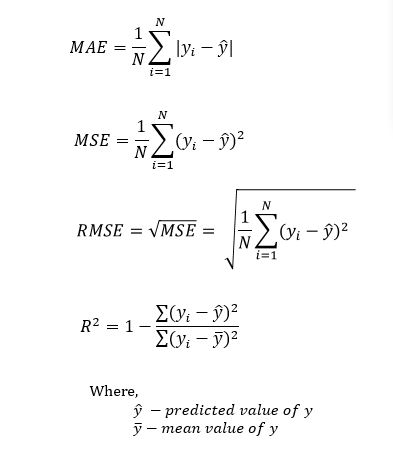

In [ ]:
print("На обучающей выборке: ")
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'MAE', 'MSE', 'RMSE', 'R^2'], fill_color='paleturquoise', align='left'),
                 cells=dict(values=[['LinearRegression', 'Lasso', 'Ridge', 'RandomForestRegressor', 'GradientBoostingRegressor', 'KNeighborsRegressor'],
                                    [1188057.631, 1179726.769, 1179711.925, 349879.301, 753635.134, 73063.192],
                                    [3629872478635.094, 3727159693747.247, 3727159924349.997, 455802834302.591, 1373452182808.109, 93107881212.236],
                                    [1905222.422, 1930585.324, 1930585.384, 675131.716, 1171943.763, 305135.841],
                                    [0.685, 0.684, 0.684, 0.961, 0.882, 0.992]],
                             fill_color='lavender', align='left'))])
fig.show()

На обучающей выборке: 


In [ ]:
import plotly.graph_objects as go
print("На тестовой выборке:")
fig = go.Figure(data=[go.Table( header=dict(values=['Model', 'MAE', 'MSE', 'RMSE', 'R^2'], fill_color='paleturquoise', align='left'),
                 cells=dict(values=[['LinearRegression', 'Lasso', 'Ridge', 'RandomForestRegressor', 'GradientBoostingRegressor', 'KNeighborsRegressor'],
                                    [1185891.159, 1205941.200, 1205932.156, 838510.271, 927110.600, 870637.446],
                                    [3833467533908.612, 3599387883879.303, 3599383273731.864, 2430287317343.647, 2612025004783.770, 3187983507084.452],
                                    [1957924.292 , 1897205.282, 1897204.067, 1558937.881, 1616176.044, 1785492.511],
                                    [0.688, 0.693, 0.693, 0.822, 0.794, 0.749]],
                             fill_color='lavender', align='left'))])
fig.show()

На тестовой выборке:


По результатам оценки моделей мы выбрали модели Случайный лес и Градиентный бустинг как наиболее точные. 